# CS985MLDAGroup21
Ian Richardson 202074007 <br>
Fraser Bayne 202053049 <br>
Slav Ivanov 201645797 <br>
Lora Kiosseva 202082329 <br>

To acheve our final set of predictions we tried to visually explore the data set and we employed some pre-processing techniques.

We made an attempt to join similar genres together. For example, we put glam rock and album rock togehter, under the more genreal genre- rock. We then tried to one hot encode the genres, however that didn't seem to improve our models. We also tried one hot encoding all genres, but that did not seem to help either.

We finally ended up using a set of models and testing them against each other using RMSE. Our best performing model turned out to be Random Forest Regression with scaled data. We also used an optimisation library to find the optimal set of parameters for our best performing model.  

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Preprocessing
from sklearn.preprocessing import StandardScaler, scale
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# ML Models
from sklearn.svm import SVC, LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

# Metrics
from sklearn.metrics import mean_squared_error

# Scikit-Optimise
from skopt import gp_minimize
from skopt.utils import cook_initial_point_generator
from skopt.space import Real, Integer

In [3]:
train_set = pd.read_csv("./dataset/CS98XRegressionTrain.csv")
test_set = pd.read_csv("./dataset/CS98XRegressionTest.csv")
train_set = train_set.rename({'pop': 'popularity'}, axis='columns')
id_column = np.array(test_set["Id"])

#An attempt to reduce the noise in training by dropping the genres for which we have very few songs. 
#Some genres tend to be more popular than others
#train_set = train_set.groupby("top genre").filter(lambda x : len(x)>=6)

In [4]:
#generating a value for each decade a song was released in
#for i in range(len(train_set.year.values)):
#    train_set.year.values[i] = str(train_set.year.values[i])[2]

#for i in range(len(test_set.year.values)):
#    test_set.year.values[i] = str(test_set.year.values[i])[2]

# Drop all rows with NaNs
train_set = train_set.dropna()

We used a correlation matrix to see if there are any strong correlations that might help us decide if we need all columns for training. There aren't any strong correlations except for the expected ones-like the louder a song is the higher energy score it has, or the more acoustic a song is, the lower energy score it has and hence it is considered less dancable. Acoustic songs seem to be less popular in our training set.

There seems to be a cutoff point at about 55 for popularity. The songs in our set could be grouped in less popular (scoring <55) and more popular (scoring >55).

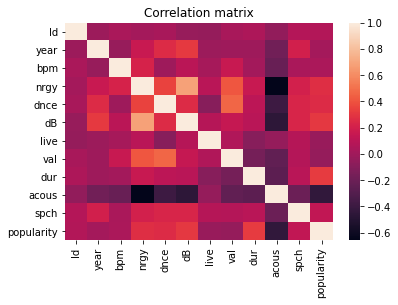

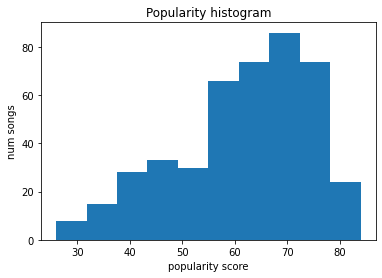

In [5]:
import seaborn as sns 

corr = train_set.corr()
sns.heatmap(corr)
plt.title("Correlation matrix")
plt.show()

plt.hist(train_set['popularity'])
plt.title("Popularity histogram")
plt.xlabel("popularity score")
plt.ylabel("num songs")
plt.show()

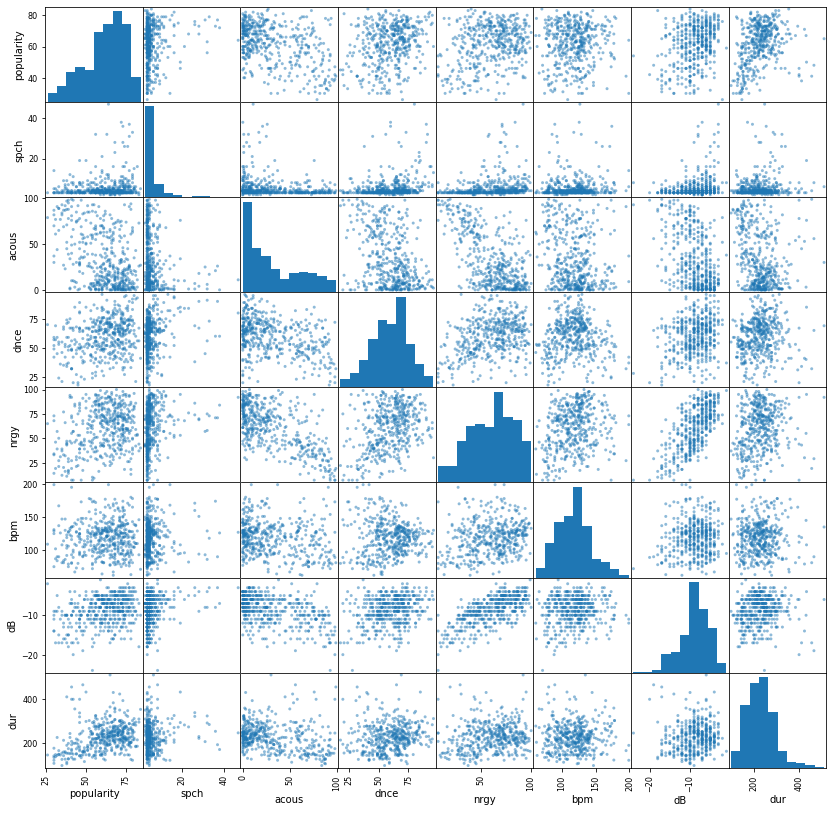

In [6]:
from pandas.plotting import scatter_matrix
attributes = ["popularity", "spch", "acous",
 "dnce", "nrgy", "bpm", "dB", "dur"]
scatter_matrix(train_set[attributes], figsize=(14, 14))
plt.show()

In [7]:
# Drop all irrelevant columns, maybe also "live", "dur", "top genre"
train_set = train_set.drop(columns=["Id", "title", "artist", "top genre"])
test_set = test_set.drop(columns=["Id", "title", "artist", "top genre"])

In [8]:
# What we want to predict
predict = "popularity"

# Get everything except what we want to predict
X = np.array(train_set.drop([predict], 1)).astype(np.float64)
# Column we want to predict
y = np.array(train_set[predict])
X_test = np.array(test_set).astype(np.float64)

In [9]:
#pca = PCA(n_components=1)
#X = pca.fit_transform(X)

#Scaling data
std_scaler = StandardScaler().fit(X)
X_scaled = std_scaler.transform(X)
X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

# Non-scaled data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)


In [10]:
# --------------
# Model Testing
# --------------

models = []

def rnd_for():
    model = RandomForestRegressor(n_estimators=1000, max_depth=25,
                                  bootstrap=True, n_jobs=-1,
                                  warm_start=True, random_state=42)
    model.fit(X_train, y_train)
    models.append(("rnd_for", model))
    y_pred = model.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    print("> Random Forest Regressor", rmse)


def knnr():
    model = KNeighborsRegressor(n_neighbors=9,
                                 n_jobs=-1)
    model.fit(X_train, y_train)
    models.append(("knnc", model))
    y_pred = model.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    print("> K-Nearest Neighbors Regressor", rmse)

def mlpr():
    model = MLPRegressor(activation = "logistic", solver="adam",
                          max_iter=10000, alpha=0.1,
                          learning_rate_init=0.05, warm_start=True,
                          learning_rate="invscaling", shuffle=False,
                          random_state=42)
    model.fit(X_train_scaled, y_train)
    models.append(("mlpr", model))
    y_pred = model.predict(X_val_scaled)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    print("> Multi-Layer Perceptron Regressor", rmse)

print("Using columns", train_set.columns.values[:len(train_set.columns.values)-1])
print("---Evaluating through rmse; lower is better---")


rnd_for()
knnr()
mlpr()

Using columns ['year' 'bpm' 'nrgy' 'dnce' 'dB' 'live' 'val' 'dur' 'acous' 'spch']
---Evaluating through rmse; lower is better---
> Random Forest Regressor 9.709133192362765
> K-Nearest Neighbors Regressor 10.24808432455707
> Multi-Layer Perceptron Regressor 12.804566302442304


Kaggle score: 7.86285
Our predictions are saved in foo.csv

The Kaggle score is higher. This is probably due to differences in the data used by us and by Kaggle to test the performance of our model. 

In [11]:
# ----------------
# Real Prediction
# ----------------
def real():
	model = RandomForestRegressor(n_estimators=1000, max_depth=25,
                                  bootstrap=True, n_jobs=-1,
                                  warm_start=True, random_state=42)
	model.fit(scale(X), y)
	y_pred = model.predict(scale(X_test))
	csv = np.stack((id_column.astype(np.int32), y_pred.astype(np.int32)), axis=1)
	csv = np.vstack((np.array(["Id","pop"]), csv))
	np.savetxt("./foo.csv", csv, fmt='%s', delimiter=",")
    
real()

The optimisation library is used to find the best setup of parameters for our best performing algorithm- the Random Forest Regressor.

In [12]:
# --------------
# Optimisation
# --------------

def f(x):
    model = RandomForestRegressor(n_estimators=x[0], max_depth=x[1],
                                  bootstrap=True, n_jobs=-1,
                                  warm_start=True, random_state=42)
    model.fit(X_train, y_train)
    models.append(("rnd_for", model))
    y_pred = model.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    return rmse

def bayesian_opt():
    lhs_maximin = cook_initial_point_generator("lhs", criterion="maximin")

    res = gp_minimize(f,
                      [Integer(2, 1000, transform='identity'),
                       Integer(2, 100, transform='identity')],
                      #xi=0.000001,
                      #kappa=0.001,
                      acq_func='EI', acq_optimizer='sampling',
                      n_calls=100, n_initial_points=10, initial_point_generator=lhs_maximin,
                      verbose = True,
                      noise = 1e-10,
                      random_state = 42)

    return (res.x, res.fun)

#print(bayesian_opt())